In [ ]:
import numpy as np
import matplotlib as plt
import h5py
import scipy
from sklearn.metrics import f1_score   
from sklearn.metrics import accuracy_score
from scipy import special
from matplotlib.pyplot import imshow
import cv2
import os
import re
import time
import keras
import gc
from keras.datasets import mnist
from keras import backend as k
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class adabound():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))

        self.defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas, final_lr=final_lr, 
                                      gamma=gamma, eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.m = {}
        self.v = {}

        for l in range(L):

            

            self.m["dw" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.m["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.v["dw" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l+1)] = np.zeros_like(parameters[l].bias)
    


    
    def step(self, state=1):

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 1:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.m["dw" + str(l + 1)] = beta1 * self.m["dw" + str(l + 1)] + (1 - beta1) * grad['dw']
                self.m["db" + str(l + 1)] = beta1 * self.m["db" + str(l + 1)] + (1 - beta1) * grad['db']

                self.v["dw" + str(l + 1)] = beta2 * self.v["dw" + str(l + 1)] + (1 - beta2) * np.power(grad['dw'], 2)
                self.v["db" + str(l + 1)] = beta2 * self.v["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                
                denom_w = np.sqrt(self.v["dw" + str(l + 1)]) + group['eps']
                denom_b = np.sqrt(self.v["db" + str(l + 1)]) + group['eps']

                bias_correction1 = 1 - beta1 ** state
                bias_correction2 = 1 - beta2 ** state
                step_size = group['lr'] * np.sqrt(bias_correction2)/ bias_correction1

                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state + group['eps']))

                step_size_w = np.full_like(denom_w, step_size)
                step_size_b = np.full_like(denom_b, step_size)

                step_size_w = np.clip(step_size_w / denom_w, lower_bound, upper_bound) * self.m["dw" + str(l + 1)] 
                step_size_b = np.clip(step_size_b / denom_b, lower_bound, upper_bound) * self.m["db" + str(l + 1)]

#               update parameters
                p.weight -= step_size_w
                p.bias -= step_size_b

In [ ]:
class adam():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas,eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.v = {}
        self.s = {}

        for l in range(L):

            

            self.v["dw" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.s["dw" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.s["db" + str(l+1)] = np.zeros_like(parameters[l].bias)

    
    def step(self, state=0):
        v_corrected = {}                         # Initializing first moment estimate, python dictionary
        s_corrected = {}

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 0:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.v["dw" + str(l + 1)] = beta1 * self.v["dw" + str(l + 1)] + (1 - beta1) * grad['dw']
                self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grad['db']

                v_corrected["dw" + str(l + 1)] = self.v["dw" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])
                v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])

                self.s["dw" + str(l + 1)] = beta2 * self.s["dw" + str(l + 1)] + (1 - beta2) * np.power(grad['dw'], 2)
                self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                s_corrected["dw" + str(l + 1)] = self.s["dw" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])
                s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])

#               update parameters
                p.weight = p.weight - group['lr'] * v_corrected["dw" + str(l + 1)] / np.sqrt(s_corrected["dw" + str(l + 1)] + group['eps'])
                p.bias = p.bias - group['lr'] * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + group['eps'])


In [ ]:
def relu(x):
  return np.maximum(0, x)

def reluDerivative(x):
  
    x[x<=0] = 0
    x[x>0] = 1
    return x

def zero_pad(x, pad):
  """
  Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
  as illustrated in Figure 1.
    
  Argument:
  x -- python numpy array of shape (m, n_h, n_w, n_c) representing a batch of m images
  pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
  Returns:
  X_pad -- padded image of shape (m, n_h + 2*pad, n_w + 2*pad, n_c)
  """

  x_pad = np.pad(x, ((0, 0), (pad, pad), (pad, pad), (0,0)), mode="constant", constant_values=(0, 0))

  return x_pad

In [ ]:
def conv_single_step(a_slice_prev, w, b):

  """
  Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
  of the previous layer.
    
  Arguments:
  a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
  w -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
  b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
  Returns:
  z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
  """

  # Element-wise product between a_slice and w
  s = a_slice_prev * w
  # Sum over all entries of the volume s
  z = np.sum(s)
  # Add bias
  z = (z + float(b))

  return z

In [ ]:
def pool_forward(a_prev, hparameters, mode="max"):
  """
  Implements the forward pass of the pooling layer
    
  Arguments:
  A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
  hparameters -- python dictionary containing "f" and "stride"
  mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
  Returns:
  A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
  cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
  """
  # Retrieve dimensions from the input shape
  m, n_h_prev, n_w_prev, n_c_prev = a_prev.shape

  stride = hparameters['stride']
  f = hparameters['f']

  # Define the dimensions of the output
  n_h = int((n_h_prev - f)/stride) + 1
  n_w = int((n_w_prev - f)/stride) + 1
  n_c = n_c_prev

  # Creating the output matrix a
  a = np.zeros((m, n_h, n_w, n_c))

  # for loop  through all of m conv channels
  for i in range(m):

    # for loop  through all of height next pooled conv channels
    for heigh in range(n_h):
      # Forming the vertical shape of the next window 
      vert_start = heigh * stride
      vert_end = heigh * stride + f

      # for loop  through all of width next pooled conv channels
      for wid in range(n_w):

        # Forming the horizontal shape of the next window 
        horiz_start = wid * stride
        horiz_end = wid * stride + f

        # for loop  through all of amount of conv channels
        for chan in range(n_c):
          # Defining the current slice on the mth training example of a_prev
          a_slice_prev = a_prev[i, vert_start:vert_end, horiz_start:horiz_end, chan]

          ## Compute the pooling operation on the slice
          if mode == "max":
            a[i, heigh, wid, chan] = np.max(a_slice_prev)
          elif mode == "average":
            a[i, heigh, wid, chan] = np.mean(a_slice_prev)
  cache = (a_prev, hparameters)

  return a, cache

In [ ]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    mask = x == np.max(x)
    
    return mask


In [ ]:
def distribute_value(dz, shape):

  """
  Distributes the input value in the matrix of dimension shape
    
  Arguments:
  dz -- input scalar
  shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
  Returns:
  a -- Array of size (n_H, n_W) for which we distributed the value of dz
  """

    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Calculate the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    
  return a

In [ ]:
def pool_backward(da, cache, mode = "max"):

  """
  Implements the backward pass of the pooling layer
    
  Arguments:
  da -- gradient of cost with respect to the output of the pooling layer, same shape as A
  cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
  mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
  Returns:
  da_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
  """
  # Unpacking the cache
  a_prev, hparameters = cache

  stride = hparameters['stride']
  f = hparameters['f']

  # Unpacking the dimensions for later forming of pooled conv derivative shape
  m, n_h_prev, n_w_prev, n_c_prev = a_prev.shape
  m, n_h, n_w, n_c = da.shape

  # Forming da_prev with zeros
  da_prev = np.zeros((m, n_h_prev, n_w_prev, n_c_prev))

  # for loop with through all of m conv channels
  for i in range(m):
    da_prev_slice = da_prev[i]

    # for loop  through all of height unpooled conv channels
    for heigh in range(n_h):

      # for loop through all of width unpooled conv channels
      for wid in range(n_w):

        # for loop  through all of amount of unpooled conv channels
        for chan in range(n_c):

          # Forming the vertical and horizontal shape of the next window 
          vert_start = heigh * stride
          vert_end = heigh * stride + f
          horiz_start = wid * stride
          horiz_end = wid * stride + f

          if mode == 'max':
            # a_slice_prev - a window for calculation of pooled conv map
            a_slice = da_prev_slice[vert_start:vert_end, horiz_start:horiz_end, chan]
            # create_mask
            mask = create_mask_from_window(a_slice)
            # Set da_prev to be da_prev + (the mask multiplied by the correct entry of da)
            da_prev[i, vert_start:vert_end, horiz_start:horiz_end, chan] += mask * da[i, heigh, wid, chan]

          if mode == 'average':
            # Define the shape of the filter as fxf
            shape = (f, f)
            # Get the value a from da
            da_slice = da[i, heigh, wid, chan]
            # Distribute it to get the correct slice of da_prev. i.e. Add the distributed value of da.
            da_prev[i, vert_start:vert_end, horiz_start:horiz_end, chan] += distribute_value(da_slice, shape)


  return da_prev

In [ ]:
class conv2d:
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, pooling=False):
        """
        param in_channels: the number of channels of the input data
        param out_channels: the number of channels of the output(aka the number of filters applied in the layer)
        param kernel_size: the specified size of the kernel(both height and width)
        param stride: the stride of convolution
        param padding: the size of padding. Pad zeros to the input with padding size.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pooling = pooling

        self.cache = None

        self._init_weights()

    def _init_weights(self):
        self.weight = 1e-3 * np.random.randn(self.kernel_size, self.kernel_size, self.in_channels, self.out_channels)
        self.bias = np.zeros((1, 1, 1, self.out_channels))

    def conv_forward(self, x, activation='relu'):

        
        # x: a conv_map from previous conv_forward
        

        # Unpacking the dimensions for later forming of new conv map shape
        a_prev = x
        m, n_h_prev, n_w_prev, n_c_prev = x.shape
        f, f, n_c_prev, n_c = w.shape

        w = self.weight
        b = self.bias

        stride = self.stride
        pad = self.padding

        # The calculations of new shape dimensions
        n_h = int((n_h_prev + 2*pad - f)/stride) + 1
        n_w = int((n_w_prev + 2*pad - f)/stride) + 1

        # z: matrix with new shape - results of convolution operation
        # a: new conv map - after activation the z matrix
        z = np.zeros((m, n_h, n_w, n_c))
        a = np.zeros((m, n_h, n_w, n_c))
        
        # Padding the input conv map
        a_prev_pad = zero_pad(a_prev, pad)

        # for loop through all of m channels
        for i in range(m):
          # Extract the mth example of previous conv map with padding
          a_prev_pad_m = a_prev_pad[i]

          # for loop through all of height image channels
          for heigh in range(n_h):
            # Forming the vertical shape of the next window 
            vert_start = heigh * stride
            vert_end = heigh * stride + f

            # for loop through all of width image channels
            for wid in range(n_w):
              # Forming the horizontal shape of the next window 
              horiz_start = wid * stride 
              horiz_end = wid * stride + f
              # for loop through all of amount of conv image out_channels
              for chan in range(n_c):
                # a_slice_prev - a window for calculation of new conv map, it has the same dimension as weights
                a_slice_prev = a_prev_pad_m[vert_start: vert_end, horiz_start: horiz_end, :]
                weights = w[:,:,:, chan]
                biases = b[:, :, :, chan]
                # Calculation the (3D) slice with the correct filter weights and biases, to get back one output neuron.
                z_slice = z[i, heigh, wid, chan] = conv_single_step(a_slice_prev, weights, biases)

                if activation == 'relu':
                  a[i, heigh, wid, chan] = relu(z_slice)

        # Making sure your output shape is correct
        assert(z.shape == (m, n_h, n_w, n_c))
        # Pooling new conv map if necessary
        if self.pooling == True:
            a, self.pool_cache = pool_forward(a, hparameters=dict(f=2, stride=2))
            

        self.cache = (a_prev, z)



        return a

    def backward(self, da):

        # da - gradient input that came from previous conv.backward during backpropagation

        # Pool backward for da, if this conv2d did pooling during the forward operation
        if self.pooling == True:
            da = pool_backward(da, self.pool_cache)

        
        stride = self.stride
        pad = self.padding

        w = self.weight
        b = self.bias
        
        # Unpacking cache and dz calculation 
        (a_prev, z) = self.cache
        dz = reluDerivative(z) * da

        # Unpacking the dimensions for later forming of new conv map shape
        m, n_h_prev, n_w_prev, n_c_prev = a_prev.shape
        f, f, n_c_prev, n_c = w.shape
        m, n_h, n_w, c = dz.shape               

        # Forming dw and db for this conv and da_prev for calculation of dz in the next conv.backward
        da_prev = np.zeros((m, n_h_prev, n_w_prev, n_c_prev))
        dw = np.zeros((f, f, n_c_prev, n_c))
        db = np.zeros((1, 1, 1, n_c))

        # Padding previous conv map and derivative 
        a_prev_pad = zero_pad(a_prev, pad)
        da_prev_pad = zero_pad(da_prev, pad)

        # for loop with through all of m channels
        for i in range(m):

          # Extract the mth examples of previous conv map and derivative with padding
          a_prev_pad_m = a_prev_pad[i]
          da_prev_pad_m = da_prev_pad[i]

          # for loop through all of height image channels
          for heigh in range(n_h):

            # for loop  through all of width image channels
            for wid in range(n_w):

              # for loop through all of amount of conv image out_channels
              for chan in range(n_c):

                # Forming the vertical and horizontal shape of the next window 
                vert_start = heigh * stride
                vert_end = heigh * stride + f
                horiz_start = wid * stride
                horiz_end = wid * stride + f

                # a_slice - a window of previous layer for calculation of derivative (dw)
                a_slice = a_prev_pad_m[vert_start:vert_end, horiz_start:horiz_end, :]

                # Calculations of dericatives
                da_prev_pad_m[vert_start:vert_end, horiz_start:horiz_end, :] += w[:, :, :, chan] * dz[i, heigh, wid, chan]
                dw[:, :, :, chan] += a_slice * dz[i, heigh, wid, chan]
                db[:, :, :, chan] += dz[i, heigh, wid, chan]

          # Set the ith training example's da_prev to the unpaded da_prev_pad_m
          da_prev[i] = da_prev_pad_m[pad:-pad, pad:-pad, :]
        
        # Calculate mean over m examples
        dw /= m
        db /= m

        grads = dict(da_prev=da_prev, dw=dw, db=db)
        self.grads = grads
        return grads

  

In [ ]:
class linear():   

  def __init__(self, in_n, out_n, activation='relu'):

    self.in_n = in_n
    self.out_n = out_n
    self.activation = activation
    self.eps = 0.000001
    self.initialize_parameters_deep([in_n, out_n])

  def initialize_parameters_deep(self, layer_dims):
  
    
    L = len(layer_dims)

    for l in range(1, L):
      self.weight = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      self.bias = np.zeros((layer_dims[l], 1))


  def linear_forward(self, a, w, b):

    z = np.dot(w, a) + b
    cache = a, w, b

    return z, cache

  def linear_activation_forward(self, a_prev, w, b, activation):

    if activation == "relu":
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.relu(z)

    if activation == "sigmoid":
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.sigmoid(z)

    if activation =='softmax':
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.softmax(z)

    cache = (linear_cache, activation_cache)
    return a, cache

  def l_linear_forward(self, x):

    a = x
    self.caches = []
    
    

    AL, cache = self.linear_activation_forward(a, self.weight, self.bias, activation=self.activation)
    self.caches.append(cache)

    return AL

  def compute_cost(self, AL, Y):
    
    AL = (AL==0) * self.eps + AL
    Y = Y.reshape(AL.shape)
    loss=-np.sum(Y*np.log(AL))
    self.dAL = AL - Y

    return loss/float(AL.shape[1])
    

  def linear_backward(self, dz, cache):

    a_prev, w, b = cache
    m = a_prev.shape[1]
    dw = 1/m * np.dot(dz, a_prev.T)
    db = 1/m * np.sum(dz, axis = 1, keepdims =True)
    dA_prev = np.dot(w.T, dz)

    return dA_prev, dw, db

  def linear_activation_backward(self, da, cache, activation):

    linear_cache, activation_cache = cache

    if self.activation == "relu":
      dz = self.relu_backward(da, activation_cache)
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    if self.activation == "sigmoid":
      dz = self.sigmoid_backward(da, activation_cache)
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    if self.activation == "softmax":
      dz = da
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    return da_prev, dw, db

  def backward(self, da_prev=0.5):

    grads = {}
    L = len(self.caches) 
    if self.activation == 'softmax':
      dAL = self.dAL
    else:
      dAL = da_prev

    current_cache = self.linear_activation_backward(dAL, self.caches[L-1], activation=self.activation)
    d_aprev_temp, dw_temp, db_temp = current_cache
    grads["da_prev"] = d_aprev_temp
    grads["dw"] = dw_temp
    grads["db"] = db_temp


    self.grads = grads
    return grads

          
    return parameters

  def softmax(self, z):

    a = special.softmax(z)
    a = np.clip(a, self.eps, 1)

    return a, z


  def relu(self, z):

    a = z * (z > 0)

    return a, z

  def relu_backward(self, da, z):

    g = 1 * (z > 0)
    dz = np.multiply(g, da)

    return dz

In [ ]:
class vgg16():
    def __init__(self, num_classes=10, shrink=7):

        self.layer1 = conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer2 = conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer3 = conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer4 = conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer5 = conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer6 = conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer7 = conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer8 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer9 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer10 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer11 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer12 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer13 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.lnn1 = linear(shrink*shrink*512, 4096)
        self.lnn2 = linear(4096, 4096)
        self.lnn3 = linear(4096, num_classes, activation='softmax')

        
    def forward(self, x, batch_size=1):
        out = self.layer1.conv_forward(x)
        out = self.layer2.conv_forward(out)
        #print(out.shape)
        out = self.layer3.conv_forward(out)
        out = self.layer4.conv_forward(out)
        #print(out.shape)
        out = self.layer5.conv_forward(out)
        out = self.layer6.conv_forward(out)
        out = self.layer7.conv_forward(out)
       # print(out.shape)
        out = self.layer8.conv_forward(out)
        out = self.layer9.conv_forward(out)
        out = self.layer10.conv_forward(out)
       # print(out.shape)
        out = self.layer11.conv_forward(out)
        out = self.layer12.conv_forward(out)
        out = self.layer13.conv_forward(out)
       # print(out.shape)
        out = out.reshape(-1, batch_size)
        #print(out.shape)
        out = self.lnn1.l_linear_forward(out)
        out = self.lnn2.l_linear_forward(out)
        out = self.lnn3.l_linear_forward(out)

        return out

    def backward(self, layers, batch_size=1):

      self.GR = []
      grads = self.lnn3.backward()
      self.GR.append(grads)

      for l in layers[0:2]: 
        grads = l.backward(grads['da_prev'])
        self.GR.append(grads)
      a_prev = self.layer13.cache[0]
      dim = int(a_prev.shape[1] / 2)
      grads['da_prev'] = grads['da_prev'].reshape(batch_size, dim, dim, 512)
      for l in layers[2:]: 
        grads = l.backward(grads['da_prev'])
        self.GR.append(grads)

      GR = self.GR

      return GR



In [ ]:
def sp_prop(model):

  spisok = []
  spisok_l = []

  for l in model.__dict__.keys():
    spisok.append(model.__dict__[l])

  for l in reversed(spisok):
    spisok_l.append(l)
  
  return spisok_l

In [ ]:
x= np.random.randn(2, 32, 32, 1)
batch_size = x.shape[0]
model = vgg16(num_classes=10, shrink=x.shape[1]//32)
params = sp_prop(model)
params.reverse()
opt = adabound(params=params)

In [ ]:
AA = model.forward(x, batch_size)
loss = model.lnn3.compute_cost(AA, np.array(np.eye(20)[1]).reshape(-1, 2))
layers = sp_prop(model)
grads = model.backward(layers[1:], x.shape[0])
opt.step(state=1)

In [ ]:
import tensorflow as tf
from matplotlib import pyplot
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


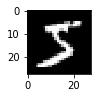

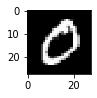

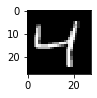

In [ ]:
for i in range(3):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:
# expand new axis, channel axis 
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)
# it's always better to normalize 
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
# resize the input shape , i.e. old shape: 28, new shape: 32
x_train, x_test = tf.image.resize(x_train, [32,32]), tf.image.resize(x_test, [32,32]) # if we want to resize 
# one-hot 
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
x_train.shape

TensorShape([60000, 32, 32, 1])

In [ ]:
print(x_train.shape, y_train.shape)

(60000, 32, 32, 1) (60000, 10)


In [ ]:
# Batch_size
X_train, Y_train, X_val, Y_val = [], [], [], []
batch_size = 3
for i in range(0, 60, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_train.append(x_train[start_idx:end_idx])
  Y_train.append(y_train[start_idx:end_idx].reshape(10, batch_size))

for i in range(0, 10, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_val.append(x_test[start_idx:end_idx])
  Y_val.append(y_test[start_idx:end_idx].reshape(10, batch_size))

In [ ]:
X_val[0].shape

TensorShape([3, 32, 32, 1])

In [ ]:
import gc
for i in range(10):
  gc.collect()

In [ ]:
x = X_val[0]

shrink = x.shape[1]//32
batch_size = x.shape[0]
print('shrink = ', shrink, 'batch_size = ', batch_size)

model = vgg16(num_classes=10, shrink=shrink)
params = sp_prop(model)
#print(params)
params.reverse()
opt = adabound(params, lr=1e-3, betas=(0.9, 0.999), final_lr=7.5e-3, gamma=1e-5,
                 eps=1e-8, weight_decay=0, amsbound=False)

y = Y_val[2]
print(y.reshape(y.shape[1], y.shape[0]))

running_loss = 0
Layers = sp_prop(model)
num_epoch = 10

for i in range(1, num_epoch + 1):

  y_true, y_preds, TR, PR = [], [], [], []
  running_loss = 0
  opt.initialize_state(params)

  for x, y in zip(X_val[2:3], Y_val[2:3]):

    out = model.forward(x, batch_size)
    loss = model.lnn3.compute_cost(out, y)
    running_loss += loss
    grads = model.backward(Layers[1:], batch_size)
    opt.step(i)

    out, y = out.reshape(out.shape[1], out.shape[0]), y.reshape(y.shape[1], y.shape[0])
    print(out)
    y_preds.extend(out)
    y_true.extend(y)

    PR.extend(np.argmax(out, axis=1))
    TR.extend(np.argmax(y, axis=1))

  
  
  y_true = np.array(y_true, dtype=np.int16)
  y_preds = np.array(y_preds, dtype=np.int16)

  print('loss = ', running_loss)
  print('f1_macro = ', f1_score(TR, PR, average='macro'))
  print('accuracy = ', accuracy_score(TR, PR))








shrink =  1 batch_size =  3
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]]
loss =  3.4011973816621555
f1_macro =  0.0
accuracy =  0.0
[[0.03323049 0.03322954 0.03323143 0.03354649 0.03355015 0.03354591
  0.03327254 0.03327453 0.03327447 0.033234  ]
 [0.03323545 0.03323453 0.03322107 0.0332214  0.0332219  0.03324247
  0.03324256 0.03324327 0.03355729 0.03356094]
 [0.03355607 0.03324626 0.03324662 0.03324696 0.03353294 0.03353692
  0.03353247 0.03324407 0.03324394 0.03324331]]
loss =  3.3947382295212556
f1_macro =  0.5
accuracy =  0.6666666666666666
[[0.03302975 0.03302363 0.03302944 0.0339773  0